## 使用ライブラリの読み込み

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## データをimportする

In [2]:
data = pd.read_csv("retail_sample_data.csv")

## データを包括的に見る

In [3]:
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L
0,15,blue,S,41.0,Adidas,P
1,13,red,S,74.0,Puma,P
2,12,grey,S,896.0,Puma,P
3,14,red,M,556.0,Puma,L
4,14,grey,M,755.0,Puma,P


In [4]:
data.describe()

,inventory_qty,Price
count,38.000000,32.000000
mean,580.921053,469.906250
std,3486.906888,282.897378
min,9.000000,41.000000
25%,13.250000,276.750000
50%,16.000000,430.500000
75%,17.000000,668.500000
max,21510.000000,990.000000


### 欠損値の確認

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 6 columns):
inventory_qty    38 non-null int64
Color            38 non-null object
Size             38 non-null object
Price            32 non-null float64
Brand            38 non-null object
P/L              38 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 1.9+ KB


ここで、`Price`に欠損値が含まれているのがわかる。

## Step1. 各変数ごとの分析

### 1. inventory_qty

在庫数を表すので、離散的数値と見なす以外はあまり考えられない。

#### 外れ値の検出

seabornというデータ可視化に特化したライブラリを使用し、外れ値を視覚的に検知する。<br>
ここでは箱ひげ図（Box Plot）と正規図（Distribution Plot）を描写し、外れ値を見つける。

[Text(0.5, 0, '')]

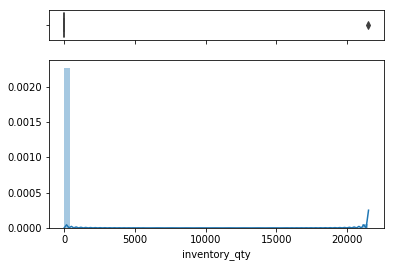

In [6]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["inventory_qty"], ax=ax_box)
sns.distplot(data["inventory_qty"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

図で明らかなように、一つだけ数値が突出しているデータがある。以下では、このデータ（外れ値）を取り除き、再度プロットしてみる。

In [7]:
data = data[data["inventory_qty"] <= 1500]

[Text(0.5, 0, '')]

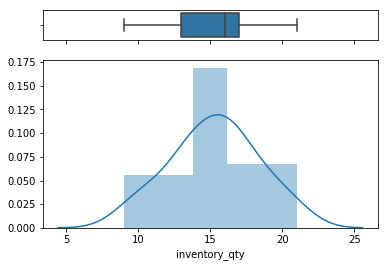

In [8]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["inventory_qty"], ax=ax_box)
sns.distplot(data["inventory_qty"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')

外れ値のあるデータを取り除くことができたのがわかる。

### 2. Color

色は文字列であり、色による優位性は※今回ないため、明らかにカテゴリカルデータである。<br>
※色の明るさによって目的変数が変わりそうであれば、これを数値に変換することも可能である。

文字列データは分析がしづらいため、数値に加工する必要がある。<br>
blue = 0, red = 1, grey = 2のように番号を採番しても良いが、これをbooleanの変数の集合体であると見なす方がいい。<br>
というのも、この数値に意味がないからだ。<br>
つまり、この`Color`という一つのカラムから、blueか否か、redか否か、greyか否かというようなbooleanな複数カラムに加工するということ。<br>
これを<b>ダミー変数変換</b>という。

In [9]:
data_color = pd.get_dummies(data['Color'])

In [10]:
data = pd.concat([data, data_color], axis=1)

In [11]:
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow
0,15,blue,S,41.0,Adidas,P,1,0,0,0
1,13,red,S,74.0,Puma,P,0,0,1,0
2,12,grey,S,896.0,Puma,P,0,1,0,0
3,14,red,M,556.0,Puma,L,0,0,1,0
4,14,grey,M,755.0,Puma,P,0,1,0,0


カテゴリカルデータであった`Color`という一カラムを、離散的数値の複数カラムに変換した。<br>
ちなみに、元のカラムは機械学習の直前まで使用するかもしれないので、残しておく。

### 3. Size 

サイズはS,M,L,XLのような文字列で表される。大きさを示しているので、数値に変換し、離散的数値として扱う場合が多い。<br>
見方によってはこれを大きさではなく、あくまでカテゴリとして扱うこともできる。<br>
その場合、`Color`のようにbooleanの変数の集合体でもいいと思う。<br>
今回は、離散的数値として扱うために数値変換を行う。

In [12]:
data_size = data['Size'].drop_duplicates().reset_index()
data_size['size_num'] = [1,2,3,4]

In [13]:
#Left Joinする
data = pd.merge(left=data,right=data_size, how='left', left_on='Size', right_on='Size')
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow,index,size_num
0,15,blue,S,41.0,Adidas,P,1,0,0,0,0,1
1,13,red,S,74.0,Puma,P,0,0,1,0,0,1
2,12,grey,S,896.0,Puma,P,0,1,0,0,0,1
3,14,red,M,556.0,Puma,L,0,0,1,0,3,2
4,14,grey,M,755.0,Puma,P,0,1,0,0,3,2


### 4. Price

Priceは離散的数値の場合もあるし連続的数値にも取れる。<br>
というのも店によっては小数点単位で値段設定しているので。<br>
既に欠損値があることがわかっているので、まずは欠損値を処理する。<br>
※欠損値を処理しないと、plotを作成する際にエラーになることがあるので、優先すること。

#### 欠損値処理

特徴量エンジニアリング（Feature engineering）を学習すると、欠損値処理の作法を学べる。<br>
今は、あまり深入りするとややこしいので簡単な欠損値処理を紹介する。<br>
と言ってもとてもシンプルで、平均値を欠損箇所に埋めるだけ。<br>

平均値は、`median`、`mode`, `mean`のどれかだが、今回は独断で`median`を使用する。

In [14]:
median_price = np.median(data['Price'].dropna())
median_price

420.0

In [18]:
data['price_adj'] = data['Price'].fillna(median_price)
data.head()

,inventory_qty,Color,Size,Price,Brand,P/L,blue,grey,red,yellow,index,size_num,price_adj
0,15,blue,S,41.0,Adidas,P,1,0,0,0,0,1,41.0
1,13,red,S,74.0,Puma,P,0,0,1,0,0,1,74.0
2,12,grey,S,896.0,Puma,P,0,1,0,0,0,1,896.0
3,14,red,M,556.0,Puma,L,0,0,1,0,3,2,556.0
4,14,grey,M,755.0,Puma,P,0,1,0,0,3,2,755.0


箱ひげ図（Box Plot）と正規図（Distribution Plot）を描写し、外れ値がないか確認する。

[Text(0.5, 0, '')]

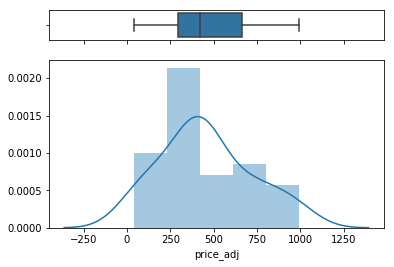

In [17]:
# Cut the window in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Add a graph in each part
sns.boxplot(data["price_adj"], ax=ax_box)
sns.distplot(data["price_adj"], ax=ax_hist)
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')